# Opening a Chinese restaurant in Edinburgh

# Import libraries

In [1]:
import pandas as pd
import json
!pip install geopy
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!pip install folium
import folium
import numpy as np
print("Libraries imported and installed")

Libraries imported and installed


# read data and pre-processing

## Plot popular area in Edinburgh

In [2]:
data = [['Old_Town', 55.948726, -3.186815], 
        ['New_Town', 55.952972, -3.200384], 
        ['Leith', 55.975485, -3.170548], 
        ['Stockbridge', 55.958805, -3.210040], 
        ['Bruntsfield', 55.935706, -3.209900],
        ['Haymaket', 55.946128, -3.216803],
        ['Corstorphine', 55.942760, -3.282341],
        ['Portobello', 55.952860, -3.114287],
        ['South_Leith', 55.963663, -3.177896],
        ['Southside', 55.939108, -3.179524]]

df = pd.DataFrame(data, columns = ['Region', 'Latitude', 'Longitude']) 

df.style.set_caption("Selected Dinning Districts in Edinburgh")

,Region,Latitude,Longitude
0,Old_Town,55.948726,-3.186815
1,New_Town,55.952972,-3.200384
2,Leith,55.975485,-3.170548
3,Stockbridge,55.958805,-3.210040
4,Bruntsfield,55.935706,-3.209900
5,Haymaket,55.946128,-3.216803
6,Corstorphine,55.942760,-3.282341
7,Portobello,55.952860,-3.114287
8,South_Leith,55.963663,-3.177896
9,Southside,55.939108,-3.179524


In [3]:
map_edinburgh = folium.Map(location=[55.951947, -3.193543], zoom_start=13)
title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format('Popular Dinning Districts in Edinburgh')  
map_edinburgh.get_root().html.add_child(folium.Element(title_html))
for lat, lng, region in zip(df['Latitude'], df['Longitude'], df['Region']):
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=region,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_edinburgh)  
    
map_edinburgh

## Using foursquare to get nearby restaurants

In [4]:
CLIENT_ID = '3N0SR5V4HMX20CMRYQEB2KWYEJTQAYBOL20DCVHP3TEMCF13' # your Foursquare ID
CLIENT_SECRET = 'LAR3Y5LPBH4SWJ5PBQY2K1E1MI2QZKQXZ2SRUEGNLSOVB3JU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # A default Foursquare API limit value
CATEGORY_ID = '4d4b7105d754a06374d81259'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3N0SR5V4HMX20CMRYQEB2KWYEJTQAYBOL20DCVHP3TEMCF13
CLIENT_SECRET:LAR3Y5LPBH4SWJ5PBQY2K1E1MI2QZKQXZ2SRUEGNLSOVB3JU


In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            CATEGORY_ID,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Region', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Reading various restaurants near our dinning districts

In [6]:
venues = getNearbyVenues(names=df['Region'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Old_Town
New_Town
Leith
Stockbridge
Bruntsfield
Haymaket
Corstorphine
Portobello
South_Leith
Southside


In [7]:
print(venues.shape)
venues.head()

(468, 7)


,Region,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old_Town,55.948726,-3.186815,The Edinburgh Larder,55.950080,-3.186088,Café
1,Old_Town,55.948726,-3.186815,Civerino's,55.949738,-3.188043,Pizza Place
2,Old_Town,55.948726,-3.186815,Mother India's Cafe,55.947998,-3.186139,Indian Restaurant
3,Old_Town,55.948726,-3.186815,The Holyrood 9A,55.949319,-3.182661,Gastropub
4,Old_Town,55.948726,-3.186815,Wings,55.949236,-3.189563,Wings Joint


In [8]:
total = venues.groupby('Region').count()[['Venue']].reset_index()
total.columns = ['Region','Total']
total = total.merge(df,on='Region')

map_edinburgh = folium.Map(location=[55.951947, -3.193543], zoom_start=13)
title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format('Total number of restaurant in various districts')  
map_edinburgh.get_root().html.add_child(folium.Element(title_html))
for lat, lng, region, num in zip(total['Latitude'], total['Longitude'], total['Region'], total['Total'] ):
    label = folium.Popup(region, parse_html=True) 
    p1 = [lat,lng]
    folium.Marker(p1, icon=folium.features.DivIcon(
        icon_size=(150,36),
        icon_anchor=(15,15),
        html='<div style="font-size: 16pt; color : black">'+str(num)+'</div>',
        )).add_to(map_edinburgh)
    map_edinburgh.add_child(folium.CircleMarker(p1, radius=30))
map_edinburgh

In [9]:
total = venues.groupby('Region').count()[['Venue']].reset_index()
total.columns = ['Region','Total']
total = total.merge(df,on='Region')
total.style.set_caption("Total number of restaurants in different districts")

,Region,Total,Latitude,Longitude
0,Bruntsfield,31,55.935706,-3.209900
1,Corstorphine,9,55.942760,-3.282341
2,Haymaket,74,55.946128,-3.216803
3,Leith,29,55.975485,-3.170548
4,New_Town,100,55.952972,-3.200384
5,Old_Town,100,55.948726,-3.186815
6,Portobello,11,55.952860,-3.114287
7,South_Leith,34,55.963663,-3.177896
8,Southside,37,55.939108,-3.179524
9,Stockbridge,43,55.958805,-3.210040


In [10]:
map_edinburgh = folium.Map(location=[55.955, -3.2], zoom_start=13)
title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format('Distribution of restaurants in various districts (Blue: Chinese restaurants, Red: Other restaurants)')  
map_edinburgh.get_root().html.add_child(folium.Element(title_html))
for lat, lng, Category in zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Venue Category']):
    label = region
    label = folium.Popup(Category, parse_html=True)
    if Category.find('Chinese'):
        highlight = 'red'
    else:
        highlight = 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=highlight,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_edinburgh)  
    
map_edinburgh

## Tabulate the number different restaurant in all districts

In [11]:
total = venues.groupby('Region').count()[['Venue']].reset_index()
total.columns = ['Region','Total']
chinese = venues[venues['Venue Category'].str.contains('Chinese')].groupby('Region').count()[['Venue']].reset_index()
chinese.columns = ['Region','Chinese']
indian = venues[venues['Venue Category'].str.contains('Indian')].groupby('Region').count()[['Venue']].reset_index()
indian.columns = ['Region','Indian']
japanese = venues[venues['Venue Category'].str.contains('Japanese')].groupby('Region').count()[['Venue']].reset_index()
japanese.columns = ['Region','Japanese']
asian = venues[venues['Venue Category'].str.contains('Asian')].groupby('Region').count()[['Venue']].reset_index()
asian.columns = ['Region','Other Asian']
all = total.merge(chinese,how='left',on="Region").merge(indian,how='left',on='Region').merge(japanese,how='left',on='Region').merge(asian,how='left',on='Region')
all = all.replace(np.nan,0)
all['Western']=all['Total']-all['Chinese']-all['Indian']-all['Japanese']-all['Other Asian']
all = all.astype({'Chinese': 'int', 'Indian': 'int', 'Japanese':'int', 'Other Asian':'int', 'Western':'int'})
all = all.sort_values('Total',ascending=False).reset_index(drop=True)

## Plots of the different types of restaurants

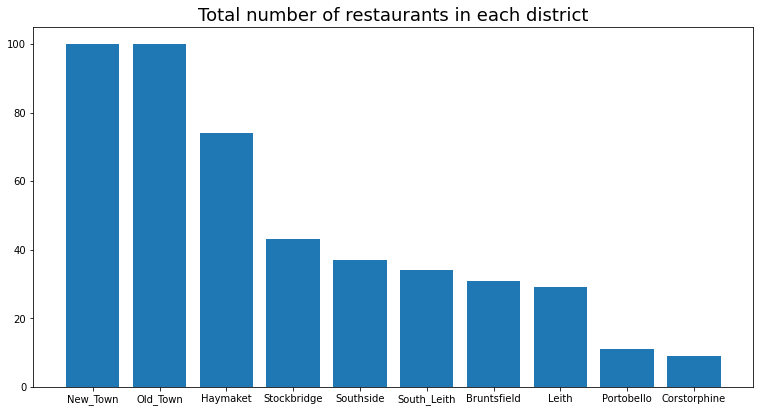

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(all['Region'],all['Total'])
ax.set_title('Total number of restaurants in each district', fontdict={'fontsize': 18, 'fontweight': 'medium'})
plt.show()

## Calculation of percentage of different types of restaurant in the same district

In [13]:
all['Chinese'] = all['Chinese']/all['Total']*100
all['Indian'] = all['Indian']/all['Total']*100
all['Japanese'] = all['Japanese']/all['Total']*100
all['Other Asian'] = all['Other Asian']/all['Total']*100
all['Western'] = all['Western']/all['Total']*100
all = all.round(decimals=1)
all[['Region','Western','Chinese','Indian','Japanese','Other Asian']].sort_values('Western',ascending=False)

,Region,Western,Chinese,Indian,Japanese,Other Asian
7,Leith,100.0,0.0,0.0,0.0,0.0
8,Portobello,100.0,0.0,0.0,0.0,0.0
3,Stockbridge,95.3,0.0,2.3,0.0,2.3
0,New_Town,93.0,1.0,3.0,1.0,2.0
1,Old_Town,92.0,0.0,7.0,1.0,0.0
5,South_Leith,88.2,2.9,8.8,0.0,0.0
2,Haymaket,87.8,4.1,6.8,1.4,0.0
4,Southside,83.8,5.4,10.8,0.0,0.0
9,Corstorphine,77.8,11.1,11.1,0.0,0.0
6,Bruntsfield,77.4,3.2,12.9,3.2,3.2


## Clustering of the data 
### one hot encoding

In [14]:
# one hot encoding
edi_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
edi_onehot.insert(loc=0, column='Region', value=venues['Region'] )
edi_onehot.head()

,Region,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Old_Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Old_Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Old_Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Old_Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Old_Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
edi_grouped = edi_onehot.groupby('Region').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Region']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Region'] = edi_grouped['Region']

for ind in np.arange(edi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(edi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Region,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Bruntsfield,Indian Restaurant,Café,Italian Restaurant,Bakery,Restaurant,Sandwich Place,Fish & Chips Shop,Gastropub,French Restaurant,Deli / Bodega
1,Corstorphine,Café,Bakery,Fish & Chips Shop,English Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Indian Restaurant,Bistro,Diner
2,Haymaket,Italian Restaurant,Café,Restaurant,Sandwich Place,Indian Restaurant,Pizza Place,Chinese Restaurant,Mexican Restaurant,Burger Joint,French Restaurant
3,Leith,Café,Seafood Restaurant,Deli / Bodega,French Restaurant,Pizza Place,Restaurant,Scottish Restaurant,Fast Food Restaurant,Italian Restaurant,Modern European Restaurant
4,New_Town,Restaurant,Café,French Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Pizza Place,Mexican Restaurant,Gastropub,Steakhouse
5,Old_Town,Café,Restaurant,Italian Restaurant,Indian Restaurant,Sandwich Place,Scottish Restaurant,Pizza Place,Seafood Restaurant,Gastropub,French Restaurant
6,Portobello,Café,Bakery,Pizza Place,Gastropub,Tapas Restaurant,Fish & Chips Shop,Bagel Shop,Bistro,Fast Food Restaurant,Greek Restaurant
7,South_Leith,Café,Bakery,Italian Restaurant,Indian Restaurant,Pizza Place,Turkish Restaurant,Chinese Restaurant,Fish & Chips Shop,Burrito Place,Restaurant
8,Southside,Café,Indian Restaurant,Korean Restaurant,Restaurant,Pizza Place,Bakery,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Malay Restaurant
9,Stockbridge,Café,Restaurant,Deli / Bodega,Sandwich Place,Italian Restaurant,French Restaurant,Bakery,Indian Restaurant,Fish & Chips Shop,English Restaurant


## Group the districts into 4 clusters using k-means clustering

In [16]:
# set number of clusters
kclusters = 4

edi_grouped_clustering = edi_grouped.drop('Region', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(edi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([1, 2, 1, 0, 1, 1, 3, 2, 1, 1], dtype=int32)

In [17]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

edi_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
edi_merged = edi_merged.join(neighborhoods_venues_sorted.set_index('Region'), on='Region')

edi_merged.head(10) # check the last columns!

,Region,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Old_Town,55.948726,-3.186815,1,Café,Restaurant,Italian Restaurant,Indian Restaurant,Sandwich Place,Scottish Restaurant,Pizza Place,Seafood Restaurant,Gastropub,French Restaurant
1,New_Town,55.952972,-3.200384,1,Restaurant,Café,French Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Pizza Place,Mexican Restaurant,Gastropub,Steakhouse
2,Leith,55.975485,-3.170548,0,Café,Seafood Restaurant,Deli / Bodega,French Restaurant,Pizza Place,Restaurant,Scottish Restaurant,Fast Food Restaurant,Italian Restaurant,Modern European Restaurant
3,Stockbridge,55.958805,-3.210040,1,Café,Restaurant,Deli / Bodega,Sandwich Place,Italian Restaurant,French Restaurant,Bakery,Indian Restaurant,Fish & Chips Shop,English Restaurant
4,Bruntsfield,55.935706,-3.209900,1,Indian Restaurant,Café,Italian Restaurant,Bakery,Restaurant,Sandwich Place,Fish & Chips Shop,Gastropub,French Restaurant,Deli / Bodega
5,Haymaket,55.946128,-3.216803,1,Italian Restaurant,Café,Restaurant,Sandwich Place,Indian Restaurant,Pizza Place,Chinese Restaurant,Mexican Restaurant,Burger Joint,French Restaurant
6,Corstorphine,55.942760,-3.282341,2,Café,Bakery,Fish & Chips Shop,English Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Indian Restaurant,Bistro,Diner
7,Portobello,55.952860,-3.114287,3,Café,Bakery,Pizza Place,Gastropub,Tapas Restaurant,Fish & Chips Shop,Bagel Shop,Bistro,Fast Food Restaurant,Greek Restaurant
8,South_Leith,55.963663,-3.177896,2,Café,Bakery,Italian Restaurant,Indian Restaurant,Pizza Place,Turkish Restaurant,Chinese Restaurant,Fish & Chips Shop,Burrito Place,Restaurant
9,Southside,55.939108,-3.179524,1,Café,Indian Restaurant,Korean Restaurant,Restaurant,Pizza Place,Bakery,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Malay Restaurant


In [18]:
edi_merged[['Region','Cluster Labels']].sort_values('Cluster Labels').reset_index(drop=True)

,Region,Cluster Labels
0,Leith,0
1,Old_Town,1
2,New_Town,1
3,Stockbridge,1
4,Bruntsfield,1
5,Haymaket,1
6,Southside,1
7,Corstorphine,2
8,South_Leith,2
9,Portobello,3


## Map of neighborhoods in different clusters

In [19]:
# create map
map_clusters = folium.Map(location=[55.955, -3.2], tiles='cartodbpositron', zoom_start=13)
title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format('Clusters of the dining districts')  
map_clusters.get_root().html.add_child(folium.Element(title_html))

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(edi_merged['Latitude'], edi_merged['Longitude'], edi_merged['Region'], edi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [20]:
edi_merged.loc[edi_merged['Cluster Labels'] == 0, edi_merged.columns[[0] + list(range(4, edi_merged.shape[1]))]]

,Region,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
2,Leith,Café,Seafood Restaurant,Deli / Bodega,French Restaurant,Pizza Place,Restaurant,Scottish Restaurant,Fast Food Restaurant,Italian Restaurant,Modern European Restaurant


## Cluster 2

In [21]:
edi_merged.loc[edi_merged['Cluster Labels'] == 1, edi_merged.columns[[0] + list(range(4, edi_merged.shape[1]))]]

,Region,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Old_Town,Café,Restaurant,Italian Restaurant,Indian Restaurant,Sandwich Place,Scottish Restaurant,Pizza Place,Seafood Restaurant,Gastropub,French Restaurant
1,New_Town,Restaurant,Café,French Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Pizza Place,Mexican Restaurant,Gastropub,Steakhouse
3,Stockbridge,Café,Restaurant,Deli / Bodega,Sandwich Place,Italian Restaurant,French Restaurant,Bakery,Indian Restaurant,Fish & Chips Shop,English Restaurant
4,Bruntsfield,Indian Restaurant,Café,Italian Restaurant,Bakery,Restaurant,Sandwich Place,Fish & Chips Shop,Gastropub,French Restaurant,Deli / Bodega
5,Haymaket,Italian Restaurant,Café,Restaurant,Sandwich Place,Indian Restaurant,Pizza Place,Chinese Restaurant,Mexican Restaurant,Burger Joint,French Restaurant
9,Southside,Café,Indian Restaurant,Korean Restaurant,Restaurant,Pizza Place,Bakery,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Malay Restaurant


## Cluster 3

In [22]:
edi_merged.loc[edi_merged['Cluster Labels'] == 2, edi_merged.columns[[0] + list(range(4, edi_merged.shape[1]))]]

,Region,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
6,Corstorphine,Café,Bakery,Fish & Chips Shop,English Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Indian Restaurant,Bistro,Diner
8,South_Leith,Café,Bakery,Italian Restaurant,Indian Restaurant,Pizza Place,Turkish Restaurant,Chinese Restaurant,Fish & Chips Shop,Burrito Place,Restaurant


## Cluster 4

In [23]:
edi_merged.loc[edi_merged['Cluster Labels'] == 3, edi_merged.columns[[0] + list(range(4, edi_merged.shape[1]))]]

,Region,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
7,Portobello,Café,Bakery,Pizza Place,Gastropub,Tapas Restaurant,Fish & Chips Shop,Bagel Shop,Bistro,Fast Food Restaurant,Greek Restaurant


# The end